# Assignment 2

In [325]:
from math import pi
import jax.numpy as jnp
from itertools import product
from matplotlib import pyplot as plt
from scipy.stats import norm
from jax.scipy.special import logsumexp
import numpy as np
from jax import grad
from PIL import Image
import pandas as pd

##  2. Implementing the Model

In [339]:
def log1pexp(x):
    """
    x: ndarray with shape (d1, d2, ..., dk)
    
    returns log1pexp of x (elementwise)
    
    As I didn't find an equivalent for log1pexp in python, I used logsumexp to implement it.
    Note that log1pexp(x) = log(exp(0) + exp(x)) = logsumexp([0, x])
    """
    zeros = jnp.zeros_like(x)
    z = jnp.concatenate((x[..., jnp.newaxis], zeros[..., jnp.newaxis]), axis=-1)
    
    return logsumexp(z, axis=-1)

In [340]:
def log_prior(zs):
    """
    zs: ndarray with shape (K, N)
    """
    return -0.5 * jnp.sum(jnp.log(2 * pi) + zs ** 2, axis=1, keepdims=True)  # shape: (K, 1)


def logp_i_beats_j(zi, zj):
    return -log1pexp(jnp.array(zj - zi)).item()


def all_games_log_likelihood(zs, games):
    """
    zs: ndarray with shape (K, N)
    games: ndarray with shape (M, 2)
    """
    zs_a = zs[:, games[:, 0]]  # skills of winners with shape: (K, M)
    zs_b = zs[:, games[:, 1]]  # skills of losers with shape: (K, M)

    likelihoods = jnp.sum(-log1pexp(zs_b - zs_a), axis=1, keepdims=True)  # shape: (K, 1)
    
    return likelihoods


def joint_log_density(zs, games):
    """
    zs: ndarray with shape (K, N)
    games: ndarray with shape (M, 2)
    """
    return log_prior(zs) + all_games_log_likelihood(zs, games)  # shape: (K, 1)


## 3. Visualize the Model on Toy Data

### 3.1. Toy Data

In [341]:
def two_player_toy_games(p1_wins, p2_wins):
    return jnp.vstack((jnp.array([[0, 1]]).repeat(p1_wins, axis=0), 
                       jnp.array([[1, 0]]).repeat(p2_wins, axis=0)))

In [342]:
two_player_toy_games(5, 3)

DeviceArray([[0, 1],
             [0, 1],
             [0, 1],
             [0, 1],
             [0, 1],
             [1, 0],
             [1, 0],
             [1, 0]], dtype=int32)

### 3.2. 2D Posterior Visualization

In [445]:
def skill_countour(f, colour=None):
    n = 100
    x = jnp.linspace(-3, 3, num=n).tolist()
    y = jnp.linspace(-3, 3, num=n).tolist()
    z_grid = jnp.array(list(product(x, y)))  # shape: (n**2, 2)
    z = f(z_grid)  # shape: (n**2, 1)
    z = z[:,0]  # shape: (n**2,)
    max_z = max(z)
    levels = [level * max_z for level in [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]]
    
    if colour is None:
        p1 = plt.contour(x, y, z.reshape(n, n).T, levels=levels)
    else:
        p1 = plt.contour(x, y, z.reshape(n, n).T, colors=colour, levels=levels)
        
def plot_line_equal_skill():
    plt.plot(jnp.linspace(-3, 3, num=200), jnp.linspace(-3, 3, num=200), label='Equal skill')

1. Isocontours of the prior distribution over players' skills:

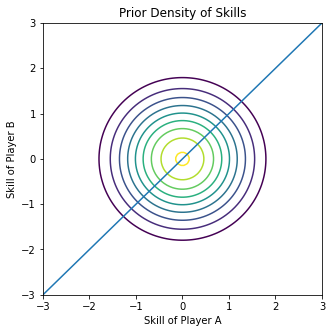

In [449]:
f = lambda zs: jnp.exp(log_prior(zs))
fig = plt.figure(figsize=(5, 5))
plot_line_equal_skill()
plt.title('Prior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f);

2. Isocontours of the likelihood function:

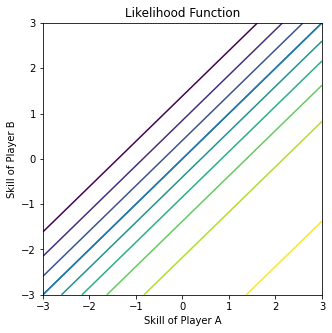

In [450]:
f = lambda zs: jnp.exp(jnp.array([[logp_i_beats_j(el[0], el[1])] for el in zs]))
fig = plt.figure(figsize=(5, 5))
plot_line_equal_skill()
plt.title('Likelihood Function')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

3. Isocontours of the posterior over players' skills given the observaton: player A beat player B
in 1 game.

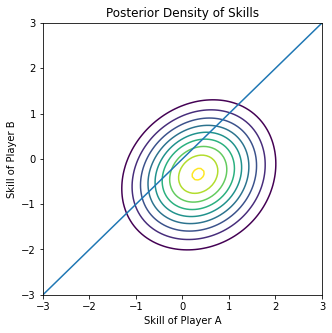

In [451]:
def f(zs):
    games = two_player_toy_games(1,0)
    return jnp.exp(joint_log_density(zs, games)) 
fig = plt.figure(figsize=(5, 5))
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

4. Isocontours of the posterior over players' skills given the observation: player A beat player B
in 10 games .

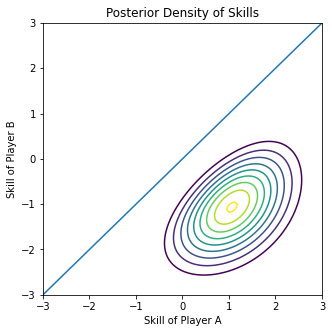

In [452]:
def f(zs):
    games = two_player_toy_games(10,0)
    return jnp.exp(joint_log_density(zs, games)) 
fig = plt.figure(figsize=(5, 5))
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

5. Isocontours of the posterior over players' skills given the observation: 20 games were played,
player A beat player B in 10 games .

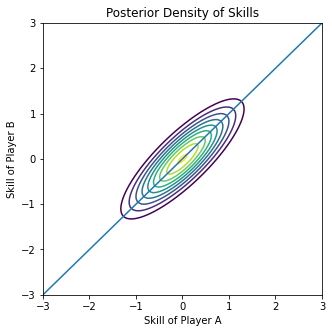

In [453]:
def f(zs):
    games = two_player_toy_games(10,10)
    return jnp.exp(joint_log_density(zs, games)) 
fig = plt.figure(figsize=(5, 5))
plot_line_equal_skill()
plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')
skill_countour(f)

## 4. Stochastic Variational Inference with Automatic Differentiation

In [366]:
def elbo(params, logp, num_samples):
    mu, ls = params['mu'], params['ls']  # mu & ls are arrays with shepe (N,)
    
    # reparametrization
    epsilon = jnp.array(np.random.randn(num_samples, mu.shape[0]))  # shape: (B, N)
    samples = epsilon * ls + mu  # shape: (B, N)
    
    logp_estimate = jnp.mean(logp(samples))
    
    """
    q is a factorized Gaussian distribution. Note that logq is exactly equal to the
    likelihoods of samples before reparametrization since the reparametrization does
    not change the probabilities! Therefore we can compute the log likelihoos of epsilons
    instead of samples.
    """
    logq_estimate = jnp.mean(jnp.sum(-0.5 * (jnp.log(2 * pi) + epsilon ** 2), axis=1))

    return logp_estimate - logq_estimate


def neg_elbo(params, games=two_player_toy_games(1, 0), num_samples=100):
    def logp(zs):
        return joint_log_density(zs, games)
    
    return -elbo(params, logp, num_samples)

In [367]:
def learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=10, 
                                         print_every=10):
    
    params_list = []  # a list to save parameters which will be used to create an animation
    grad_fn = grad(neg_elbo, argnums=0)
    params_cur = init_params
    
    def f_true_posterior(zs):
        return jnp.exp(all_games_log_likelihood(zs, toy_evidence) + joint_log_density(zs, toy_evidence))
    
    def f_var(zs):
        mu, ls = params_cur['mu'], params_cur['ls']
        out = jnp.prod((1/((2*pi) ** 0.5 * ls)) * jnp.exp(-0.5 * ((zs - mu) / ls) ** 2), axis=1, keepdims=True)
        return out
    
    for i in range(num_iters):
        grad_params = grad_fn(params_cur, toy_evidence, num_q_samples)
        neg_elbo_cur = neg_elbo(params_cur, toy_evidence, num_q_samples)
        params_list.append(params_cur)
        
        if i % print_every == 0:
            print(f'Iteration {i}, Loss: {neg_elbo_cur}')
            
        for p in params_cur:
            params_cur[p] -= grad_params[p] * lr
    
    skill_countour(f_true_posterior, colour='red')
    skill_countour(f_var, colour='blue')
    
    return params_list

## 5. Visualizing SVI on Two Player Toy

In [368]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([0.5, 1.])}

Iteration 0, Loss: -0.4424629211425781
Iteration 20, Loss: -0.3572847843170166
Iteration 40, Loss: -0.5338113307952881
Iteration 60, Loss: -0.4425196647644043
Iteration 80, Loss: -0.6429100036621094
Iteration 100, Loss: -0.40958166122436523
Iteration 120, Loss: -0.6125197410583496
Iteration 140, Loss: -0.2226250171661377
Iteration 160, Loss: -0.45930933952331543
Iteration 180, Loss: -0.349743127822876


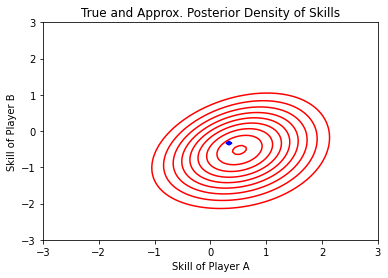

In [370]:
toy_evidence = two_player_toy_games(1, 0)

plt.title('True and Approx. Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')

list_params = learn_and_vis_toy_variational_approx(init_params, 
                                                   toy_evidence, 
                                                   num_iters=200, 
                                                   lr=1e-2, 
                                                   num_q_samples=100,
                                                   print_every=20)

In [ ]:
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots()
ax.axis('equal')

def animate(i):
    x = np.linspace(0, 4, 1000)
    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(x, y)
    return line,

Iteration 0, Loss: 56.6224250793457
Iteration 20, Loss: 16.283864974975586
Iteration 40, Loss: 5.083802223205566
Iteration 60, Loss: 2.084383010864258
Iteration 80, Loss: 1.4942588806152344
Iteration 100, Loss: 1.4194388389587402
Iteration 120, Loss: 1.2842555046081543
Iteration 140, Loss: 1.2374720573425293
Iteration 160, Loss: 1.2511992454528809
Iteration 180, Loss: 1.3082833290100098


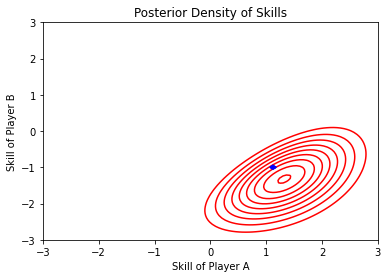

In [355]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([2, 2.3])}

toy_evidence = two_player_toy_games(10, 0)

plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')

learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=100,
                                    print_every=20)

Iteration 0, Loss: 473.05535888671875
Iteration 20, Loss: 298.543701171875
Iteration 40, Loss: 194.763916015625
Iteration 60, Loss: 108.18434143066406
Iteration 80, Loss: 66.40141296386719
Iteration 100, Loss: 34.62166976928711
Iteration 120, Loss: 19.920467376708984
Iteration 140, Loss: 13.8596773147583
Iteration 160, Loss: 12.979717254638672
Iteration 180, Loss: 13.013548851013184


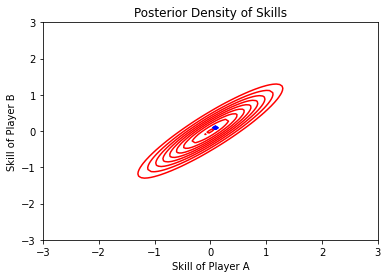

In [356]:
init_params = {'mu': jnp.array([-2.,3.]), 'ls': jnp.array([20., 11.])}

toy_evidence = two_player_toy_games(10, 10)

plt.title('Posterior Density of Skills')
plt.xlabel('Skill of Player A')
plt.ylabel('Skill of Player B')

learn_and_vis_toy_variational_approx(init_params, toy_evidence, num_iters=200, lr=1e-2, num_q_samples=100,
                                    print_every=20)

## 6. Approximate inference on real data

### Reading the data

In [243]:
df_games = pd.read_csv('games.csv')
df_names = pd.read_csv('names.csv')

games = df_games.values
names = df_names['name'].values.tolist()

games.shape, len(names)

((286889, 2), 51983)

### Dataloader

In [210]:
from math import ceil

def dataloader(data, batch_size, shuffle=True):
    if shuffle:
        np.random.shuffle(data)
    
    num_iters = ceil(data.shape[0] / batch_size)
    
    for i in range(num_iters):
        yield data[i * batch_size:(i+1) * batch_size]

### Variational Distribution

1. In general is $p(z_i, z_j | \text{all games})$ proportional to $p(z_i, z_j, \text{all games})$?
Yes
2. In general is $p(z_i, z_j | \text{all games})$ proportional to $p(z_i, z_j, \text{games between i and j})$? That is do the games between player $i$ and $j$ provide all the information about the skills $z_i$ and $z_j$? No.

In [214]:
def elbo(params, logp, num_samples):
    mu, log_ls = params['mu'], params['log_ls']  # mu & sigma are arrays with shepe (N,)
    
    epsilon = jnp.array(np.random.randn(num_samples, mu.shape[0]))  # shape: (B, N)
    
    samples = epsilon * jnp.exp(log_ls) + mu  # shape: (B, N)
    logp_estimate = logp(samples)  # shape: (B, 1)
    
    '''
    To calculate log_q we can compute the pdfs before transforming the samples since the transformation
    does not change the likelihood!
    '''
    logq_estimate = jnp.sum(-0.5 * (jnp.log(2 * pi) + epsilon ** 2), axis=1)  # shape: (B, 1)

    return jnp.mean(logp_estimate - logq_estimate)


def neg_elbo(params, games, num_samples=100):
    def logp(zs):
        return joint_log_density(zs, games)
    
    return -elbo(params, logp, num_samples)

### Train loop

In [219]:
def learn_variational_approx(init_params, games, num_epochs, lr=1e-2, num_q_samples=10, print_every=100):
    params_cur = init_params

    grad_fn = grad(neg_elbo, argnums=0)
    iters = 0 
    losses = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}')
        for X_batch in dataloader(games, batch_size=256, shuffle=True):
            grad_params = grad_fn(params_cur, X_batch, num_q_samples)
            
            loss = neg_elbo(params_cur, X_batch, num_q_samples)
            losses.append(loss)
            
            if iters % print_every == 0:
                print(f'\tIteration {iters}, Loss: {loss}')
            
            for p in params_cur:
                params_cur[p] -= grad_params[p] * lr
            
            iters += 1
    
    return losses, params_cur

In [222]:
%%time

init_params = {'mu': jnp.array(np.random.randn(len(names),)), 'log_ls': jnp.array(np.random.randn(len(names),))}

losses, params_cur = learn_variational_approx(init_params, games, num_epochs=1, lr= 1e-2, num_q_samples = 10)

Epoch 1
	Iteration 0, Loss: 190868.8125
	Iteration 100, Loss: -14631.8876953125
	Iteration 200, Loss: -20788.841796875
	Iteration 300, Loss: -22553.037109375
	Iteration 400, Loss: -23179.79296875
	Iteration 500, Loss: -23745.125
	Iteration 600, Loss: -23990.626953125
	Iteration 700, Loss: -24260.5703125
	Iteration 800, Loss: -24444.1796875
	Iteration 900, Loss: -24583.2265625
	Iteration 1000, Loss: -24649.98828125
	Iteration 1100, Loss: -24826.869140625
CPU times: user 1min 48s, sys: 6.96 s, total: 1min 55s
Wall time: 1min 26s


plot losses during ELBO optimization and report final loss:

Final loss: -24807.582


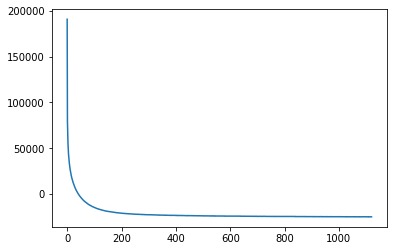

In [225]:
print('Final loss:', losses[-1])
plt.plot(losses);

sort players by mean skill under our moidel and list top 10 players.

In [275]:
params_names_joint = list(zip(params_cur['mu'], params_cur['log_ls'], names))
players_sorted = sorted(params_names_joint, key = lambda item: item[0], reverse=True)

In [276]:
print('mu \t log_ls \t name')
players_sorted[:10]

mu 	 log_ls 	 name


[(0.5165517, -2.8236015, 'sandro_mikanovic'),
 (0.27862325, -1.6863353, 'alex-brien'),
 (0.20391288, -1.9242855, 'sacsthexchange'),
 (0.19324574, -1.9010447, 'girijanr'),
 (0.17026603, -2.0633178, 'ypradafah'),
 (0.15009859, -1.7122997, 'seyyarmuhendis'),
 (0.14437158, -1.8715721, 'vesper2018'),
 (0.1367519, -2.1305869, 'usuba'),
 (0.12889488, -1.7174602, 'hezalian'),
 (0.12146654, -2.0640867, 'mustapha04')]

plot mean and variance of all players, sorted by skill:

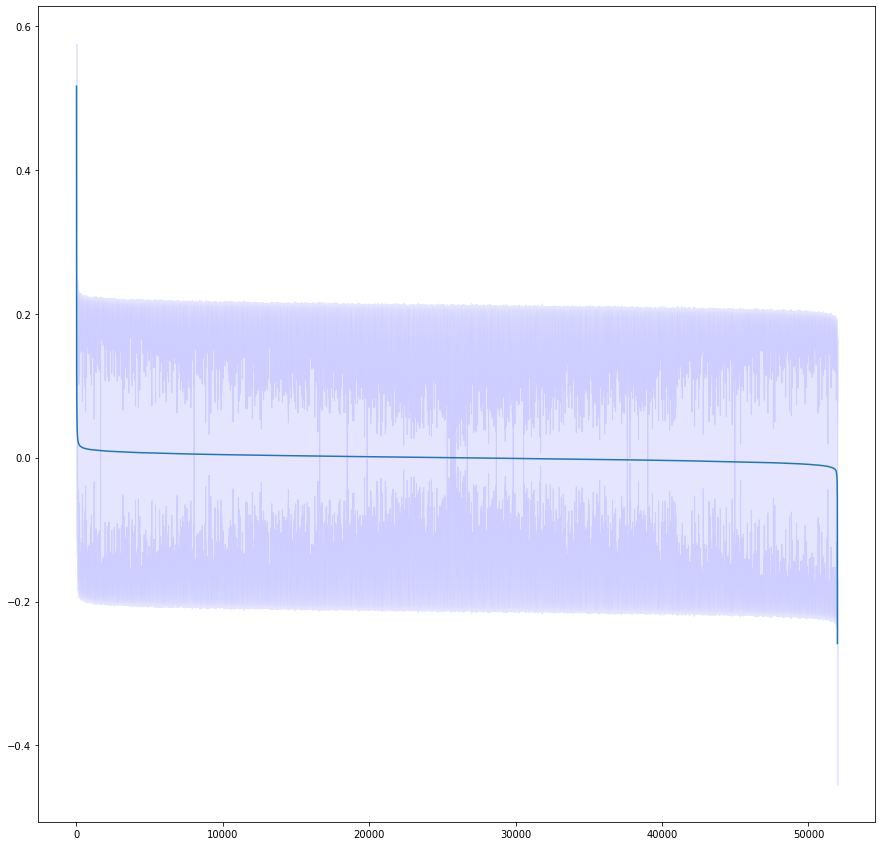

In [271]:
plt.figure(figsize=(15, 15))

ys = [item[0] for item in players_sorted]
error_ys = [jnp.exp(item[1]) for item in players_sorted]

plt.plot(ys, '-')

plt.fill_between(list(range(len(players_sorted))), 
                 [y - error_y for y , error_y in zip(ys, error_ys)], 
                 [y + error_y for y , error_y in zip(ys, error_ys)],
                 color='blue', 
                 alpha=0.1);

## 7. More Approximate Inference with our Model

In [314]:
camillab, liverpoolborn, meri_arabidze, sylvanaswindrunner = None, None, None, None 

for i, item in enumerate(players_sorted):
    name = item[2]
    if name == 'camillab':
        camillab = i
    elif name == 'liverpoolborn':
        liverpoolborn = i
    elif name == 'meri-arabidze':
        meri_arabidze = i
    elif name == 'sylvanaswindrunner':
        sylvanaswindrunner = i

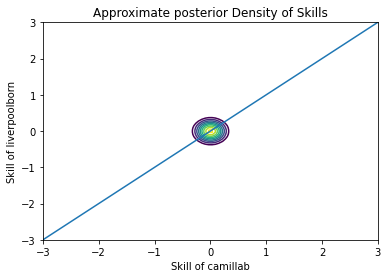

In [315]:
camillab_mean, camillab_std  = players_sorted[camillab][0], jnp.exp(players_sorted[camillab][1])
liverpoolborn_mean, liverpoolborn_std  = players_sorted[liverpoolborn][0], jnp.exp(players_sorted[liverpoolborn][1])

means = jnp.array([camillab_mean, liverpoolborn_mean])
stds = jnp.array([camillab_std, liverpoolborn_std])

f = lambda zs: jnp.exp(jnp.sum(-0.5 * jnp.log(2 * pi) - jnp.log(stds) - 0.5 * ((zs - means) / stds) ** 2, 
                                      axis=1, 
                                      keepdims=True))
plot_line_equal_skill()
plt.title('Approximate posterior Density of Skills')
plt.xlabel('Skill of camillab')
plt.ylabel('Skill of liverpoolborn')
skill_countour(f)

In [316]:
n_sample = 1000
skills = np.random.randn(n_sample, 2) * stds + means
print('Prob. of liverpoolborn more skillful than camillab:', (jnp.sum(skills[:, 0] < skills[:, 1]) / n_sample).item())

Prob. of liverpoolborn more skillful than camillab: 0.47099998593330383


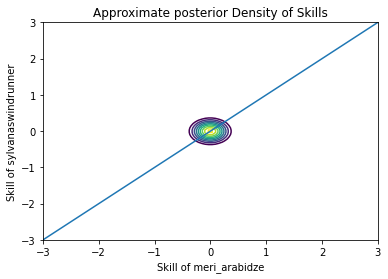

In [317]:
meri_arabidze_mean, meri_arabidze_std  = players_sorted[meri_arabidze][0], jnp.exp(players_sorted[meri_arabidze][1])
sylvanaswindrunner_mean, sylvanaswindrunner_std  = players_sorted[sylvanaswindrunner][0], jnp.exp(players_sorted[sylvanaswindrunner][1])

means = jnp.array([meri_arabidze_mean, sylvanaswindrunner_mean])
stds = jnp.array([meri_arabidze_std, sylvanaswindrunner_std])

f = lambda zs: jnp.exp(jnp.sum(-0.5 * jnp.log(2 * pi) - jnp.log(stds) - 0.5 * ((zs - means) / stds) ** 2, 
                                      axis=1, 
                                      keepdims=True))
plot_line_equal_skill()
plt.title('Approximate posterior Density of Skills')
plt.xlabel('Skill of meri_arabidze')
plt.ylabel('Skill of sylvanaswindrunner')
skill_countour(f)

In [321]:
n_sample = 1000
skills = np.random.randn(n_sample, 2) * stds + means
print('Prob. of sylvanaswindrunner more skillful than meri_arabidze:', (jnp.sum(skills[:, 0] < skills[:, 1]) / n_sample).item())

Prob. of sylvanaswindrunner more skillful than meri_arabidze: 0.5120000243186951
